# HW3

**Author:** Tianyu

**Course:** Physics 434 - Data Analysis Lab  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(434)

<>:62: SyntaxWarning: invalid escape sequence '\h'
<>:62: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-4053141204.py:62: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel('N'); plt.ylabel('Std. error of $\hat{\pi}$')


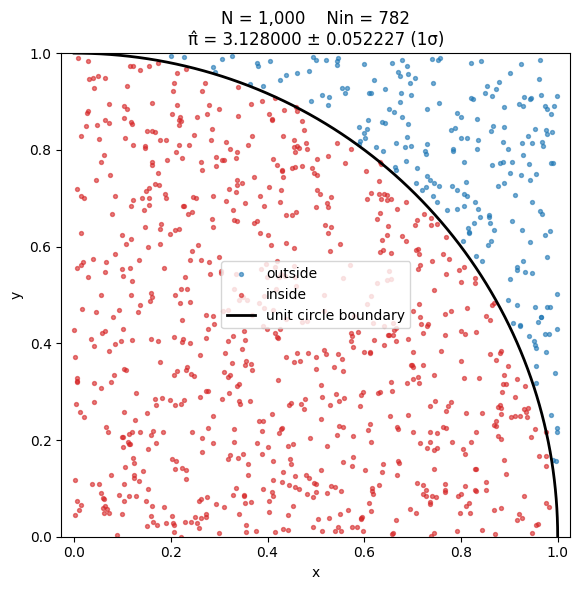

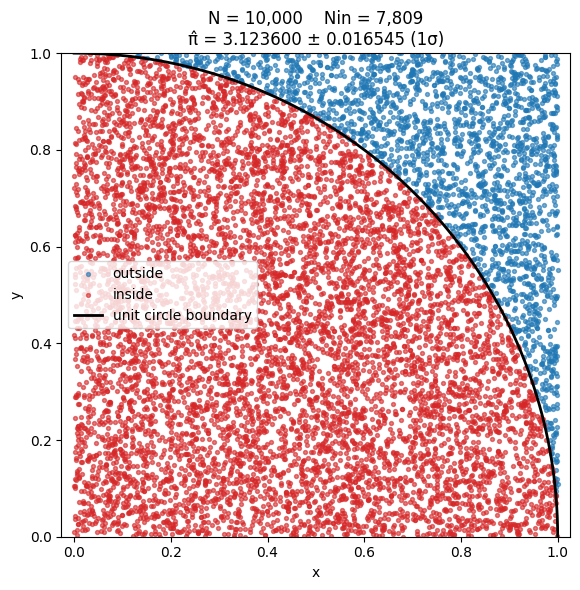

/tmp/ipython-input-4053141204.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


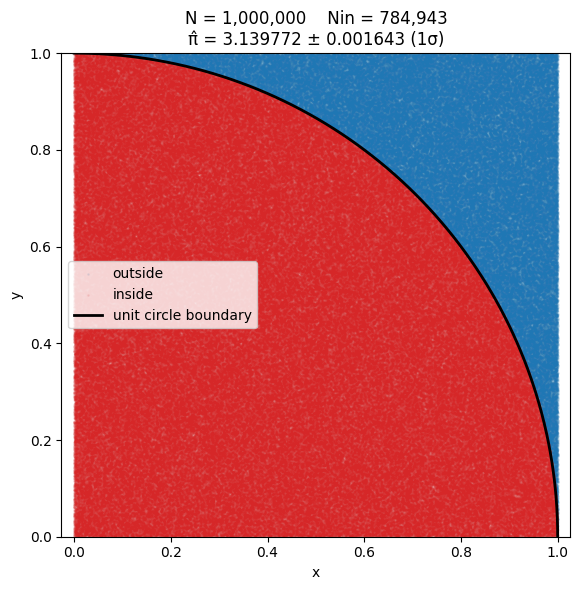


Monte Carlo π estimates (with counts):

           N          N_in      pi_hat         ±1σ                   95% CI   rel.err%       z
       1,000           782    3.128000    0.052227  [3.025636, 3.230364]     0.4327    0.26
      10,000         7,809    3.123600    0.016545  [3.091171, 3.156029]     0.5727    1.09
   1,000,000       784,943    3.139772    0.001643  [3.136551, 3.142993]     0.0580    1.11


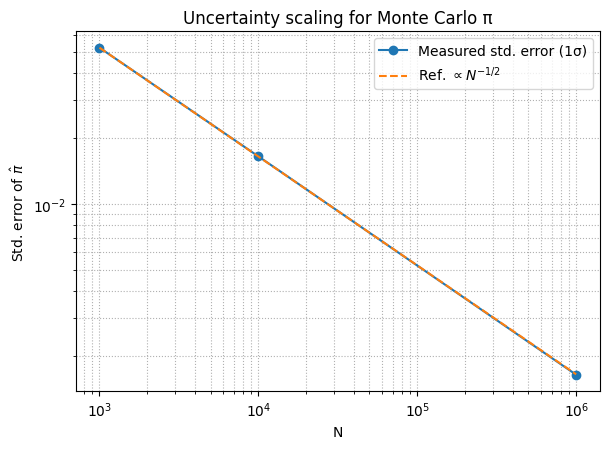


Discussion: The estimates are statistically consistent with π; absolute error shrinks roughly as N^{-1/2}, as shown by the linear trend on the log–log plot of the standard error. For N = 10^6 the 1σ uncertainty is ~10× smaller than for N = 10^4, matching the Monte Carlo scaling rule.



In [ ]:
# -----------------------------
# Part 1: Estimating pi
# -----------------------------
def mc_pi_once(N, rng):
    """Return (pi_hat, sigma_pi, x, y, inside, Nin)."""
    x = rng.random(N)
    y = rng.random(N)
    r2 = x**2 + y**2
    inside = r2 < 1.0
    Nin = int(inside.sum())
    p_hat = Nin / N
    pi_hat = 4.0 * p_hat
    # Binomial plug-in SE for p, propagated to pi
    sigma_pi = 4.0 * np.sqrt(p_hat * (1.0 - p_hat) / N)
    return pi_hat, sigma_pi, x, y, inside, Nin

# (a,b)
theta = np.linspace(0, np.pi/2, 400)
xc, yc = np.cos(theta), np.sin(theta)

Ns = [1_000, 10_000, 1_000_000]
results = []

for N in Ns:
    pi_hat, sigma_pi, x, y, inside, Nin = mc_pi_once(N, rng)
    results.append((N, Nin, pi_hat, sigma_pi))

    plt.figure(figsize=(6, 6))
    alpha_val = 0.6 if N < 100_000 else 0.08
    size_val  = 8   if N < 100_000 else 1.0

    plt.scatter(x[~inside], y[~inside], s=size_val, c='tab:blue', alpha=alpha_val, label='outside')
    plt.scatter(x[inside],  y[inside],  s=size_val, c='tab:red',  alpha=alpha_val, label='inside')
    plt.plot(xc, yc, 'k-', lw=2, label='unit circle boundary')

    plt.axis('equal'); plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('x'); plt.ylabel('y')
    plt.title(f'N = {N:,}    Nin = {Nin:,}\n'
              f'π̂ = {pi_hat:.6f} ± {sigma_pi:.6f} (1σ)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# (c,d)
print("\nMonte Carlo π estimates (with counts):\n")
print(f"{'N':>12}  {'N_in':>12}  {'pi_hat':>10}  {'±1σ':>10}  {'95% CI':>23}  {'rel.err%':>9}  {'z':>6}")
pi_hats, sigmas = [], []
for (N, Nin, pi_hat, sigma_pi) in results:
    ci95 = (pi_hat - 1.96*sigma_pi, pi_hat + 1.96*sigma_pi)
    relerr = abs(pi_hat - np.pi)/np.pi * 100.0
    z = (np.pi - pi_hat)/sigma_pi
    pi_hats.append(pi_hat); sigmas.append(sigma_pi)
    print(f"{N:12,d}  {Nin:12,d}  {pi_hat:10.6f}  {sigma_pi:10.6f}  "
          f"[{ci95[0]:.6f}, {ci95[1]:.6f}]  {relerr:9.4f}  {z:6.2f}")
plt.figure(figsize=(6.2,4.6))
plt.loglog(Ns, sigmas, 'o-', label='Measured std. error (1σ)')
ref_c = sigmas[0]*np.sqrt(Ns[0])
ref = [ref_c/np.sqrt(N) for N in Ns]
plt.loglog(Ns, ref, '--', label=r'Ref. $\propto N^{-1/2}$')
plt.xlabel('N'); plt.ylabel('Std. error of $\hat{\pi}$')
plt.title('Uncertainty scaling for Monte Carlo π')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.tight_layout()
plt.show()


disc = (
    "Discussion: The estimates are statistically consistent with π; "
    "absolute error shrinks roughly as N^{-1/2}, as shown by the linear trend "
    "on the log–log plot of the standard error. For N = 10^6 the 1σ uncertainty "
    "is ~10× smaller than for N = 10^4, matching the Monte Carlo scaling rule."
)
print("\n" + disc + "\n")


[Rejection] Proposals=30,000, Accepted=10,000, Acceptance≈0.333, Random# used=60,000
[Inverse  ] Generated=10,000, Random# used=10,000


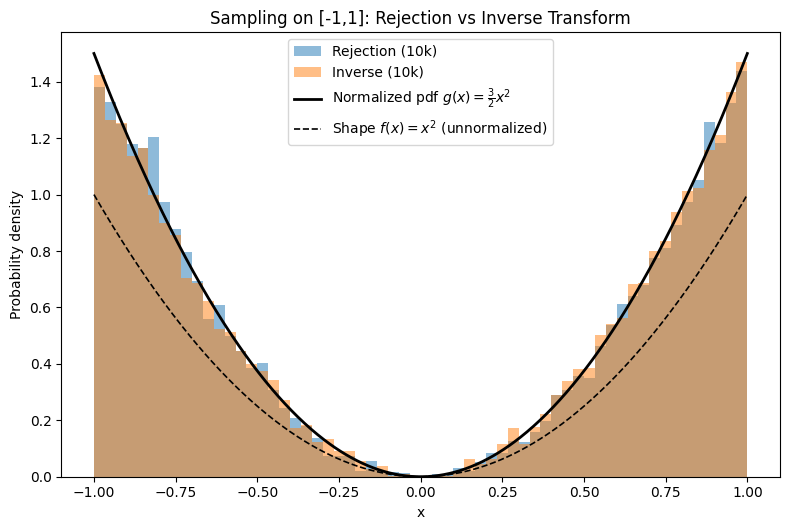


Efficiency (fewer random numbers is better):
  Rejection: 6.00 random numbers per accepted sample (≈ 3 expected).
  Inverse:   1.00 random numbers per sample (exactly 1).

Moment check vs theory for g(x):  E[X]=0,  E[X^2]=0.6
  Rejection: mean=-0.0097,  E[X^2]=0.6011
  Inverse:   mean=+0.0077,  E[X^2]=0.5954


In [ ]:
# -----------------------------
# Part 2: Parabola distribution on [-1,1] with f(x)=x^2
# We will sample from the *normalized* target pdf g(x) = (3/2) x^2 on [-1,1].
# -----------------------------
# ----- Target shapes -----
def f_shape(x):   # unnormalized target (as written in the prompt)
    return x**2

def g_pdf(x):     # normalized target pdf on [-1,1]
    return 1.5 * x**2

# ----- (a) Rejection method -----
def sample_rejection(N_accept, rng, verbose=True):
    """
    Proposal: x ~ U(-1,1), y ~ U(0, f(1)) with f(1)=1.
    Keep x if y < f(x)=x^2. Loop until N_accept are accepted.
    Returns: samples, proposals_count, random_numbers_used
    """
    samples = []
    proposals = 0
    while len(samples) < N_accept:
        m = max(10_000, N_accept - len(samples))  # vectorized chunk
        x = rng.uniform(-1, 1, size=m)
        y = rng.uniform(0.0, 1.0, size=m)        # f(1)=1
        keep = y < (x**2)
        samples.extend(x[keep].tolist())
        proposals += m
    samples = np.array(samples[:N_accept])
    rnd_used = 2 * proposals  # one uniform for x and one for y per proposal
    if verbose:
        print(f"[Rejection] Proposals={proposals:,}, Accepted={N_accept:,}, "
              f"Acceptance≈{N_accept/proposals:.3f}, Random# used={rnd_used:,}")
    return samples, proposals, rnd_used

# ----- (b) Inverse-transform method -----
# CDF for g(x) ∝ x^2 on [-1,1] is G(x) = (x^3 + 1)/2. Inverse: x = (2u - 1)^(1/3).
def sample_inverse(N, rng, verbose=True):
    # The CDF variable u must be Uniform(0,1).
    u = rng.random(N)
    x = np.cbrt(2.0*u - 1.0)  # cube-root works for negatives
    rnd_used = N              # one uniform per sample
    if verbose:
        print(f"[Inverse  ] Generated={N:,}, Random# used={rnd_used:,}")
    return x, rnd_used

# ----- (c) Generate, compare, and comment -----
N = 10_000  # required sample size

xr, props, rnd_rej = sample_rejection(N, rng)
xi, rnd_inv = sample_inverse(N, rng)

# Plot: both simulated distributions and target functions
xs = np.linspace(-1, 1, 600)
bins = 60; rng_plot = (-1, 1)

plt.figure(figsize=(8,5.4))
plt.hist(xr, bins=bins, range=rng_plot, density=True, alpha=0.5, label='Rejection (10k)')
plt.hist(xi, bins=bins, range=rng_plot, density=True, alpha=0.5, label='Inverse (10k)')
plt.plot(xs, g_pdf(xs), 'k-',  lw=2, label=r'Normalized pdf $g(x)=\frac{3}{2}x^2$')
plt.plot(xs, f_shape(xs), 'k--', lw=1.2, label=r'Shape $f(x)=x^2$ (unnormalized)')
plt.xlabel('x'); plt.ylabel('Probability density')
plt.title('Sampling on [-1,1]: Rejection vs Inverse Transform')
plt.legend()
plt.tight_layout()
plt.show()

# Efficiency + quick moment check for your writeup
print("\nEfficiency (fewer random numbers is better):")
print(f"  Rejection: {rnd_rej/N:.2f} random numbers per accepted sample (≈ 3 expected).")
print(f"  Inverse:   {rnd_inv/N:.2f} random numbers per sample (exactly 1).")

# Optional: moments of the normalized target are E[X]=0, E[X^2]=0.6
def moments(x):
    return x.mean(), (x**2).mean()
mu_r, m2_r = moments(xr)
mu_i, m2_i = moments(xi)
print("\nMoment check vs theory for g(x):  E[X]=0,  E[X^2]=0.6")
print(f"  Rejection: mean={mu_r:+.4f},  E[X^2]={m2_r:.4f}")
print(f"  Inverse:   mean={mu_i:+.4f},  E[X^2]={m2_i:.4f}")
